# This notebook shows the interpolation and spacial normalization process for each video

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import library with current code functions
sys.path.append(os.path.join("..", "lib"))
import general_functions as gf, files_paths as fp

## Defining some functions


In [2]:
def index_frames_generate(VD_INFO, VD_FEATURE):
    
    # Get video information 
    VIDEO_ID = VD_FEATURE['video_id'][0]
    FRAME_SEQ = np.array(VD_FEATURE['frame_seq'], dtype=np.int16)
    TIME_STEP_FR = VD_INFO['time_step_fr'][0]
    ORIGIN_VID = VD_INFO['origin_vid'][0]
    
    # Get the maximum value of frame_seq
    frame_seq_max = FRAME_SEQ[-1]
    
    # Make a dataframe with a video_id column and n rows (n=maximum value of frame_seq)
    FRAMES_DTFRAME = pd.DataFrame(data={'video_id': VIDEO_ID}, index=pd.RangeIndex(0,frame_seq_max+1,1), dtype=np.int16)
    FRAMES_DTFRAME['frame_seq'] = range(0,frame_seq_max+1)
    
    # Fill the collumn fr_exists with 1 in the indexes that the frame_seq number exists
    FRAMES_DTFRAME.loc[FRAME_SEQ, 'fr_exists'] = 1
    
    # Replace NaN values with zeros in 
    FRAMES_DTFRAME['fr_exists'] = FRAMES_DTFRAME['fr_exists'].fillna(0).astype(int)
    
    # Filter Dataframe to find discontinuous intervals
    FRAMES_DTFRAME['frames_total'] = (FRAMES_DTFRAME.fr_exists.diff(1) != 0).cumsum()
    FRAMES_DTFRAME = pd.DataFrame({'fr_exists' : FRAMES_DTFRAME.groupby('frames_total').fr_exists.first(),
                  'frame_seq_init' : FRAMES_DTFRAME.groupby('frames_total').frame_seq.first(), 
                  'frame_seq_end': FRAMES_DTFRAME.groupby('frames_total').frame_seq.last(),
                  'frames_total' : FRAMES_DTFRAME.groupby('frames_total').size()}).reset_index(drop=True)
    
    # Add  origin_vid collumn
    FRAMES_DTFRAME.insert(0, 'origin_vid', ORIGIN_VID)
    FRAMES_DTFRAME.insert(0, 'video_id', VIDEO_ID)
    FRAMES_DTFRAME.insert(6, 'time_step_fr', TIME_STEP_FR)

    return FRAMES_DTFRAME

In [3]:
# Function to display only the landmarks for each frame individually
def DISPLAY_LANDMARKS(VD_FEATURES, start_frame=None, end_frame=None, max_col=5, DISPLAY_ALL_FRAMES=False):

    if DISPLAY_ALL_FRAMES:
        landmarks_range = VD_FEATURES
    else:
        if test_range(start_frame, end_frame):
            landmarks_range = VD_FEATURES.query("frame_seq >= @start_frame & frame_seq <= @end_frame")
            
    len_range = len(landmarks_range)
    n_rows = (len_range + max_col-1) // max_col
    
    plt.figure(figsize=(15, n_rows*3))
    for i, (frame_number, row) in enumerate(landmarks_range.iterrows()):
        plt.subplot(n_rows, max_col, i+1)
        shape = np.array([eval(coord) for coord in row[6:]])
        x = shape[:, 0] 
        y = shape[:, 1]
    
        plt.scatter(x, y, c='black', marker='o', s=10)
        plt.text(0, 1.05, f"frame: {row.frame_seq}", transform=plt.gca().transAxes,
                 horizontalalignment='center', verticalalignment='bottom')
        plt.gca().invert_yaxis()
        plt.axis('off')
           
    plt.tight_layout()
    plt.show()  

In [4]:
class RangeError(ValueError):
    def __init__(self, message):
        self.message = message
        super().__init__(self.message)

def test_range(start_frame, end_frame):
    if end_frame < start_frame:
        raise RangeError("Error: start frame must be less than end frame.")
    else:
        return True

In [5]:
def color_interpolated_rows(row):
    if row['fr_exists'] == 0 and row['frames_total'] < 5:
        return ['color: red']*len(row)
    else: return [''] * len(row) 

## Reading CSV's

In [6]:
# D for local video or Y for online video
ORIGIN = "D"
VIDEO_ID = 22

VD_INFO = gf.READ_CSV_FILE(gf.get_video_path(ORIGIN, VIDEO_ID, fp.VD_INFO))
VD_FEATURES_L1 = gf.READ_CSV_FILE(gf.get_video_path(ORIGIN, VIDEO_ID, fp.VD_FEATURES_L1))
VD_FEATURES_L2 = gf.READ_CSV_FILE(gf.get_video_path(ORIGIN, VIDEO_ID, fp.VD_FEATURES_L2))
VD_FEATURES_L3 = gf.READ_CSV_FILE(gf.get_video_path(ORIGIN, VIDEO_ID, fp.VD_FEATURES_L3))

FileNotFoundError: [Errno 2] No such file or directory: '..\\Dataset\\DD-Local\\VD_D_0000000022\\VD_INFO.CSV'

# Let's first interpolate the video discontinuities

## Shows the video frames with it's discontinuities

In [18]:
index_frames_generate(VD_INFO, VD_FEATURES_L1).style.apply(color_interpolated_rows, axis=1)

,video_id,origin_vid,fr_exists,frame_seq_init,frame_seq_end,frames_total,time_step_fr
0,22,D,1,0,9,10,0.033333
1,22,D,0,10,26,17,0.033333
2,22,D,1,27,44,18,0.033333


## Shows the video frames interpolated

In [19]:
index_frames_generate(VD_INFO, VD_FEATURES_L2)

,video_id,origin_vid,fr_exists,frame_seq_init,frame_seq_end,frames_total,time_step_fr
0,22,D,1,0,9,10,0.033333
1,22,D,0,10,26,17,0.033333
2,22,D,1,27,44,18,0.033333


# Now let's normalize the frames captured

## Here we are going to use as the example of spacial normalization a 3D model of a head. This head will be moved in 2 axis, roll and Z (back and forwards)

In [20]:
start_frame_crop = 0
end_frame_crop = 40
n_frames_per_row = 4

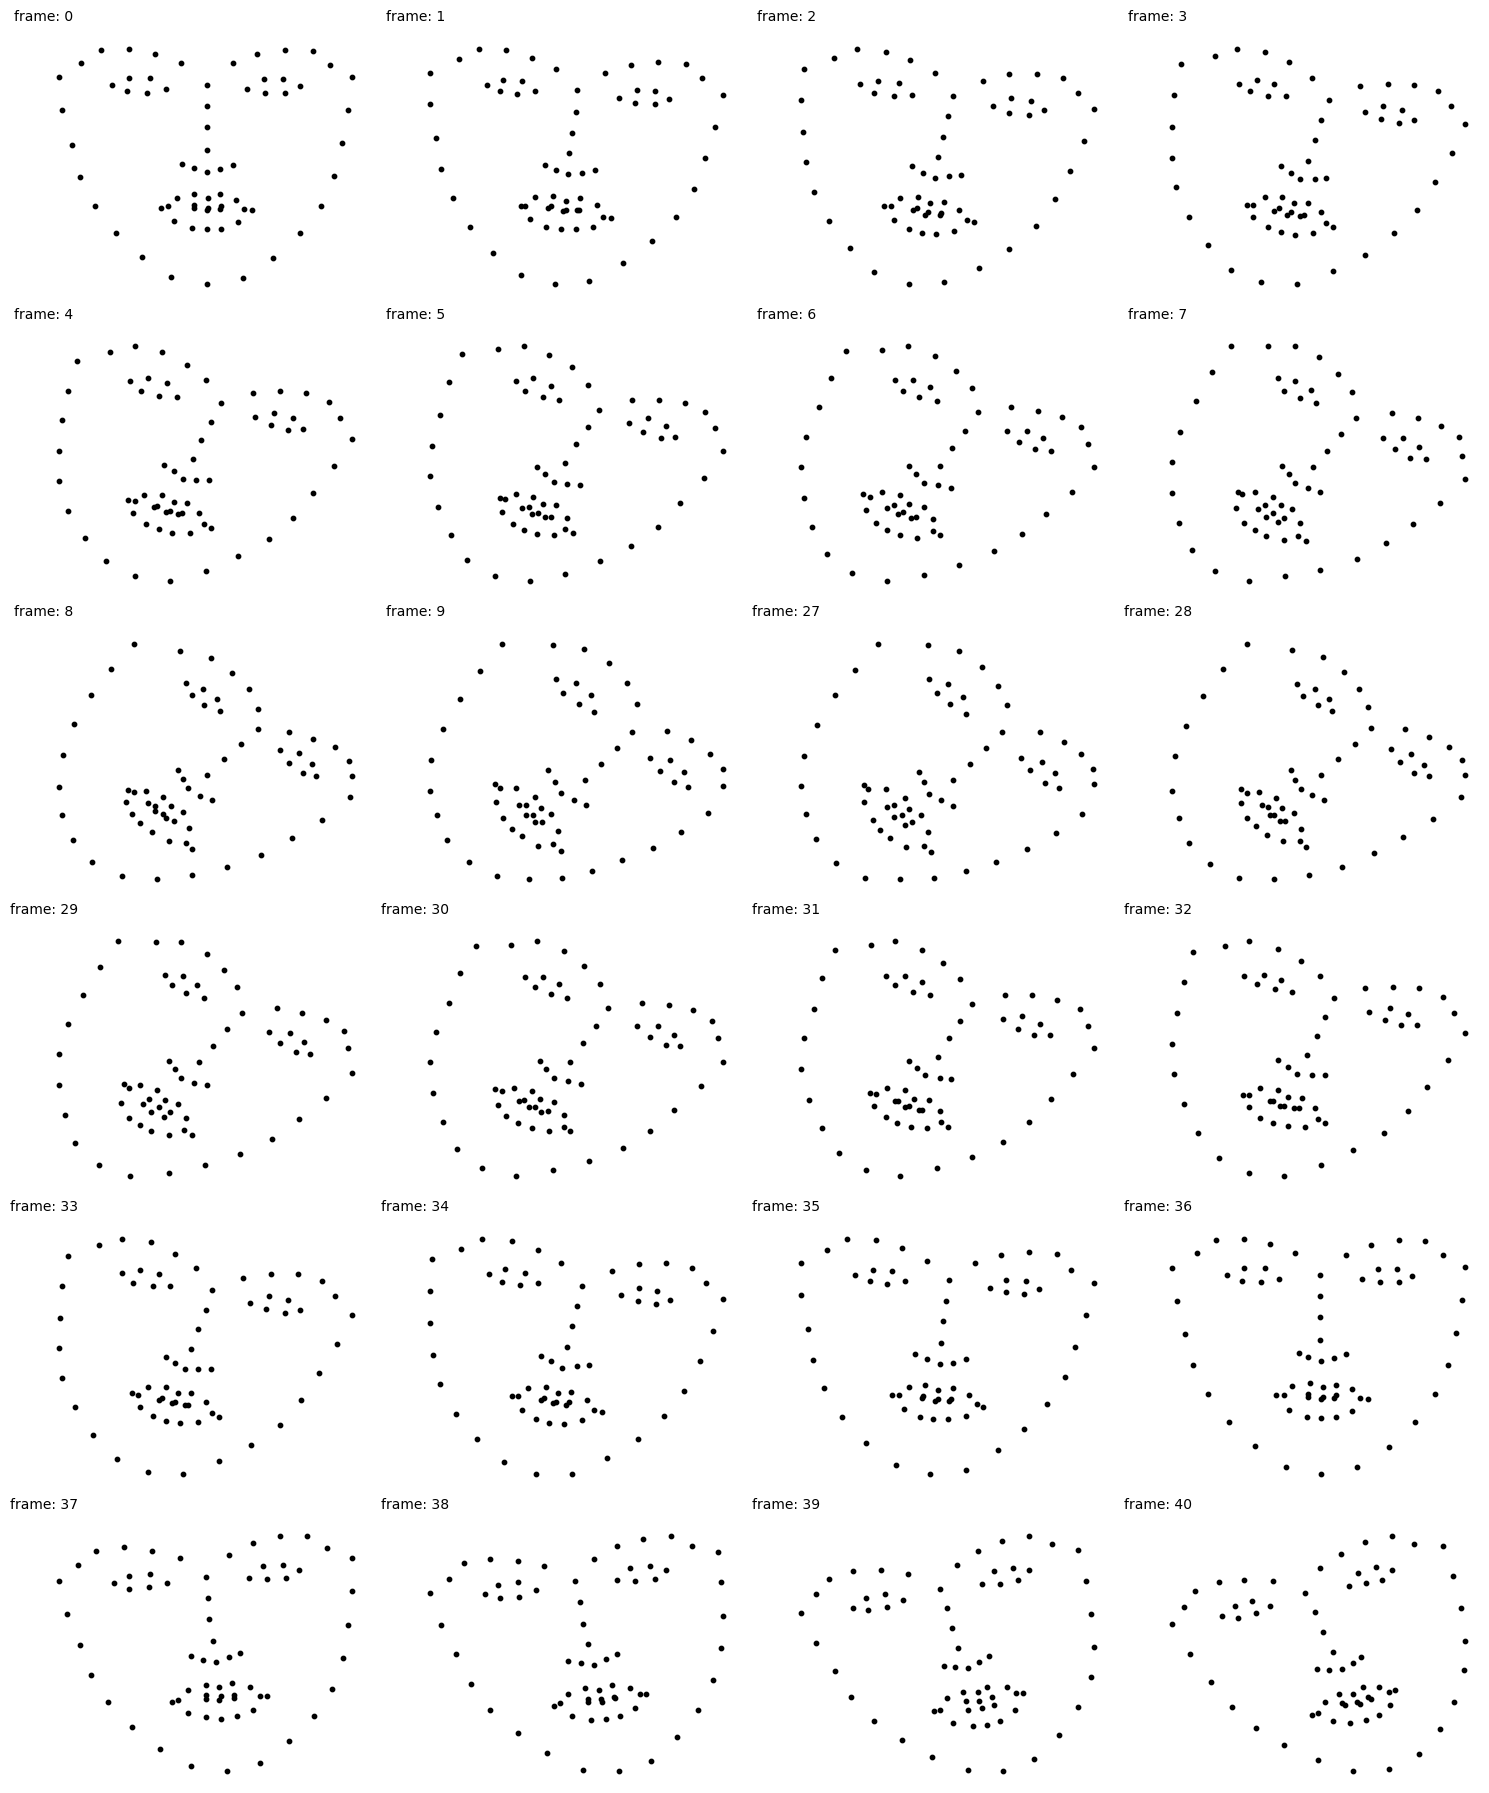

In [21]:
# Show the landmarks from the original video
DISPLAY_LANDMARKS(VD_FEATURES_L2, start_frame_crop, end_frame_crop, n_frames_per_row)

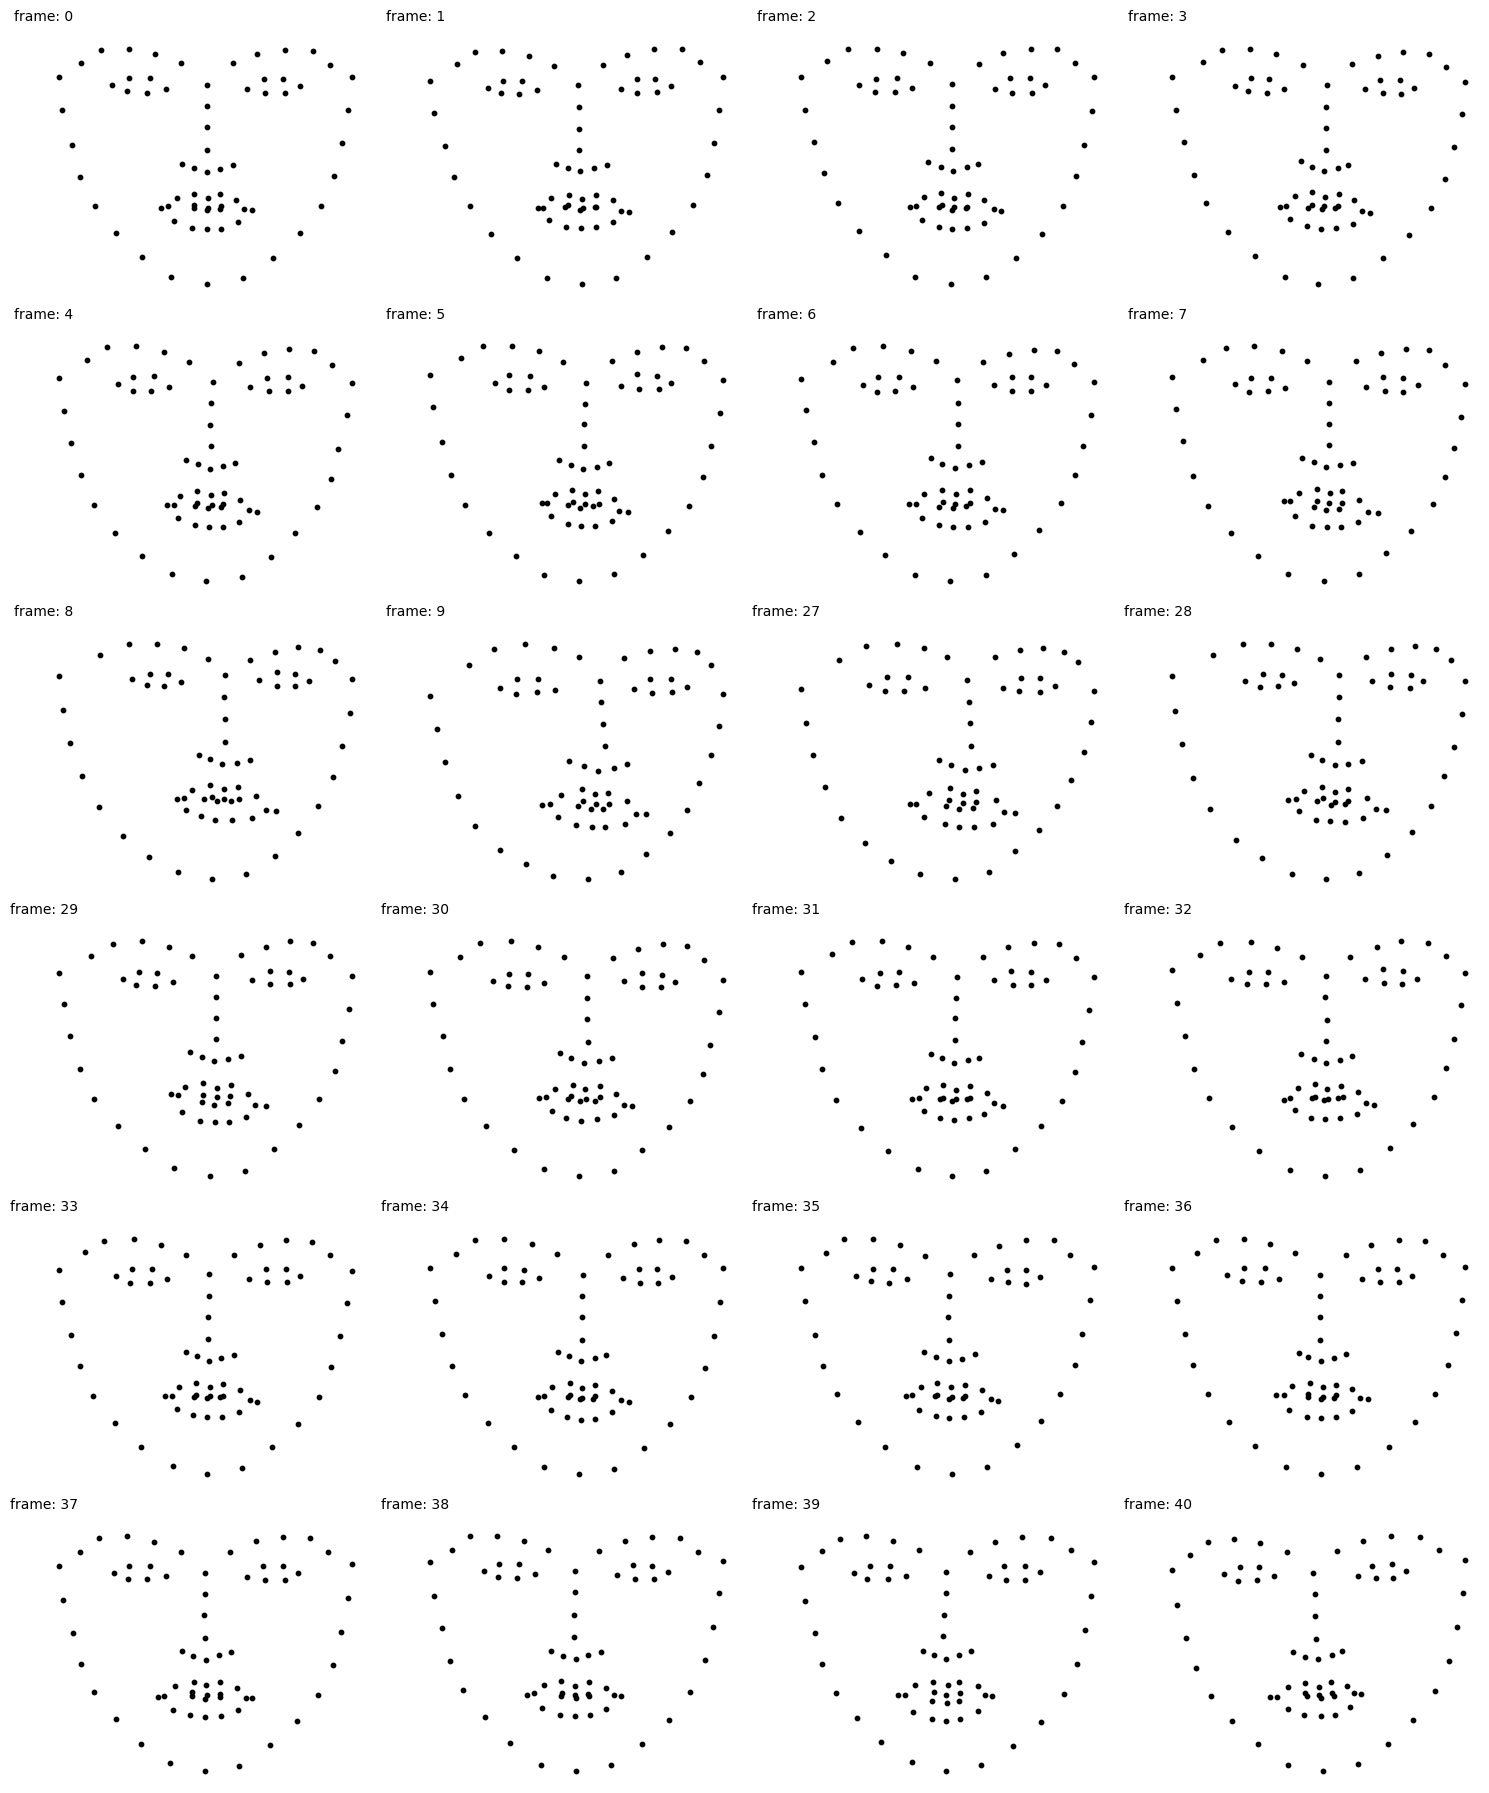

In [22]:
# Show the landmarks with Roll normalization
DISPLAY_LANDMARKS(VD_FEATURES_L3, start_frame_crop, end_frame_crop, n_frames_per_row)